In [6]:
import numpy as np
import pandas as pd
import math
import matplotlib.pyplot as plt
import random

In [7]:
df=pd.read_csv("C:\\Users\\hp\\Documents\\IAFSM_ML\\Naive_K-neighbours\\Dataset\\train.csv")
df.head()

,PassengerId,Survived,Pclass,Name,Sex,Age,SibSp,Parch,Ticket,Fare,Cabin,Embarked
0,1,0,3,"Braund, Mr. Owen Harris",male,22.0,1,0,A/5 21171,7.2500,NaN,S
1,2,1,1,"Cumings, Mrs. John Bradley (Florence Briggs Th...",female,38.0,1,0,PC 17599,71.2833,C85,C
2,3,1,3,"Heikkinen, Miss. Laina",female,26.0,0,0,STON/O2. 3101282,7.9250,NaN,S
3,4,1,1,"Futrelle, Mrs. Jacques Heath (Lily May Peel)",female,35.0,1,0,113803,53.1000,C123,S
4,5,0,3,"Allen, Mr. William Henry",male,35.0,0,0,373450,8.0500,NaN,S


In [180]:
X=df.drop(["Survived","Name","PassengerId","Ticket","Cabin"],axis=1)
Y=df["Survived"]

In [181]:
X

,Pclass,Sex,Age,SibSp,Parch,Fare,Embarked
0,3,male,22.0,1,0,7.2500,S
1,1,female,38.0,1,0,71.2833,C
2,3,female,26.0,0,0,7.9250,S
3,1,female,35.0,1,0,53.1000,S
4,3,male,35.0,0,0,8.0500,S
...,...,...,...,...,...,...,...
886,2,male,27.0,0,0,13.0000,S
887,1,female,19.0,0,0,30.0000,S
888,3,female,NaN,1,2,23.4500,S
889,1,male,26.0,0,0,30.0000,C


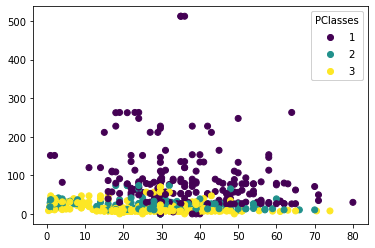

In [216]:
fig, ax = plt.subplots()
scatter=ax.scatter(X["Age"],X["Fare"],c=X["Pclass"])
legend=ax.legend(*scatter.legend_elements(), loc="upper right", title="PClasses")
ax.add_artist(legend)
plt.show()

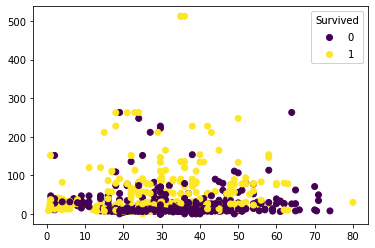

In [217]:
fig, ax = plt.subplots()
scatter=ax.scatter(X["Age"],X["Fare"],c=Y)
legend=ax.legend(*scatter.legend_elements(), loc="upper right", title="Survived")
ax.add_artist(legend)
plt.show()

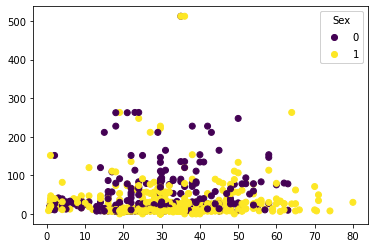

In [219]:
fig, ax = plt.subplots()
scatter=ax.scatter(X["Age"],X["Fare"],c=X_kn["Sex"])
legend=ax.legend(*scatter.legend_elements(), loc="upper right", title="Sex")
ax.add_artist(legend)
plt.show()

### From above graphs it can be concluded that most of the survivers are from 1st class and are females

In [21]:
X[["Sex"]].value_counts()

Sex   
male      577
female    314
dtype: int64

In [22]:
X[["Embarked"]].value_counts()

Embarked
S           644
C           168
Q            77
dtype: int64

In [9]:
X.describe()

,Pclass,Age,SibSp,Parch,Fare
count,891.000000,714.000000,891.000000,891.000000,891.000000
mean,2.308642,29.699118,0.523008,0.381594,32.204208
std,0.836071,14.526497,1.102743,0.806057,49.693429
min,1.000000,0.420000,0.000000,0.000000,0.000000
25%,2.000000,20.125000,0.000000,0.000000,7.910400
50%,3.000000,28.000000,0.000000,0.000000,14.454200
75%,3.000000,38.000000,1.000000,0.000000,31.000000
max,3.000000,80.000000,8.000000,6.000000,512.329200


In [36]:
for col in X.columns: ## Checking for columns with null values
    print(X[col].isna().sum())

0
0
177
0
0
0
2


### Impute  null values with mean value of age

In [111]:
def impute(X):
    X["Age"]=X["Age"].fillna(29.666)
    X["Fare"]=X["Fare"].fillna(32.204208)
    X["Parch"]=X["Parch"].fillna(0)
    X["SibSp"]=X["SibSp"].fillna(0)
    X["Embarked"]=X["Embarked"].fillna('S')
    X['Sex']=X["Sex"].fillna("male")
    X["Pclass"]=X["Pclass"].fillna(3)
    return X

In [182]:
X=impute(X)

In [39]:
for col in X.columns: ## Checking for columns with null values
    print(X[col].isna().sum())

0
0
0
0
0
0
0


In [46]:
X["Pclass"]=X["Pclass"].astype("str")

In [48]:
cat_features=[0,1,6] #columns containing categorical value
num_features=[2,3,4,5] # columns containing numerical values

### Convert categorical value into integer values

In [193]:
def encoding(X):
    # here label encoding was giving better results than one hot encoding hence it was used
    #lable encoding acc=0.7247191011235955
    #one hot encoding acc=0.6853932584269663
    """dummies=pd.get_dummies(X,columns=["Sex","Embarked"])
    dummies=dummies.drop(["Sex_female"],axis=1)"""
    for i in range(0,len(X)):
        if(X["Sex"][i]=="male"):
            X["Sex"][i]=1
        else:
            X["Sex"][i]=0
        if(X["Embarked"][i]=="S"):
            X["Embarked"][i]=0
        elif(X["Embarked"][i]=="Q"):
            X["Embarked"][i]=1
        elif(X["Embarked"][i]=="C"):
            X["Embarked"][i]=2
    
    return X

### Separates the dataset in to a subset of data for each class.

In [40]:
def separate_classes( X, y):
        separated_classes = {}
        for i in range(len(X)):
            feature_values = X[i]
            class_name = y[i]
            if class_name not in separated_classes:
                separated_classes[class_name] = []
            separated_classes[class_name].append(feature_values)
        return separated_classes


### Get priors for categorical features by making the probabilty table

In [41]:
def get_priors(sep_data):
    priors={}
    for label in sep_data:
        data=np.array(sep_data[label])
        prior_list=[]
        for feat in cat_features:
            feature=data[:,feat]
            feat_info=np.unique(feature,return_counts=True)
            class_priors=dict(zip(feat_info[0],feat_info[1]))
            for key in class_priors.keys():
                class_priors[key]=class_priors[key]/len(data)
            prior_list.append(class_priors)
        priors[label]=prior_list
    return priors

### Calculates standard deviation and mean of features and returns a dictionary with STD and Mean as keys and assigned features STD and Mean as values.

In [42]:
def stat(sep_data):
    stats={}
    for label in sep_data:
        data=np.array(sep_data[label])
        stats_list=[]
        for feat in num_features:
            feature=data[:,feat]
            std=np.std(feature)
            mean=np.mean(feature)
            
            stats_list.append(dict({"std":std,"mean":mean}))
        stats[label]=stats_list
    return stats

### Calculate the Gaussian Distribution Function and return normal probability
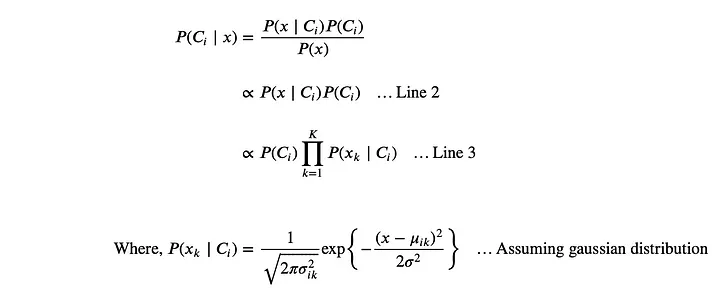

#### We find priori for continuous varibale using the above formula

In [43]:
def gaussian_distribution(std,mean,x):
    
        #x=x.astype("float32")
        #print("std=",type(std),"mean=",type(mean),"Value=",type(x))
        exponent = np.exp(-((x-mean)**2 / (2*std**2)))

        return exponent / (np.sqrt(2*np.pi)*std)


### Trains the model and returns a dictionary with the prior probability for categorical variables and mean, standard deviation for continous variables of each class

In [44]:
def fit(X,Y):
    
    sep_data=separate_classes(np.asarray(X),Y)
    priors=get_priors(sep_data)
    stat_info=stat(sep_data)
    class_summary={}
    m=X.shape[1]
    for label in sep_data:
        prior_lists=[]
        for i in range(0,m):
            if i in cat_features:
                info=priors[label][cat_features.index(i)]
            else:
                info=stat_info[label][num_features.index(i)]
            prior_lists.append(info)
        likelihood=len(sep_data[label])/len(Y)
        class_summary[label]={"likelihood":likelihood,"summary":prior_lists}
    return class_summary

### Predicts the labels by calculating prior of both continous and categorical variable by multiplying the and finding the probabiltiy using bayes theorm

In [51]:
def predict(X_test):
    y_pred=[]
    for idx in range(0,len(X_test)):
        class_prob={}
        for label in class_summary:
            likelihood=class_summary[label]["likelihood"]
            m=X_test.shape[1]
            priors=[]
            for i in range(0,m):
                if i in cat_features:
                    p=class_summary[label]["summary"][i][X_test[idx,i]]
                else:
                    
                    std=class_summary[label]["summary"][i]["std"]
                    mean=class_summary[label]["summary"][i]["mean"]
                    p=gaussian_distribution(std,mean,X_test[idx,i])
                priors.append(p)
            class_prob[label]=likelihood*np.prod(priors)
        y_pred.append(max(class_prob, key=class_prob.get))
            
    
    return y_pred

In [52]:
 def accuracy(y_test, y_pred):

        true_true = 0

        for y_t, y_p in zip(y_test, y_pred):
            if y_t == y_p:
                true_true += 1 
        return true_true / len(y_test)

In [53]:
def train_test_split(X, Y, split):

    #split=size of test dataset
    #randomly assigning split% rows to training set and rest to test set
    indices = np.array(range(len(X)))
    
    train_size = round((1-split) * len(X))

    random.shuffle(indices)

    train_indices = indices[0:train_size]
    test_indices = indices[train_size:len(X)]

    X_train = X.iloc[train_indices, :]
    X_test = X.iloc[test_indices, :]
    Y_train = Y.iloc[train_indices]
    Y_test = Y.iloc[test_indices]
    
    return np.asarray(X_train),np.asarray(X_test),np.asarray(Y_train),np.asarray(Y_test)

In [54]:
X_train,x_test,Y_train,y_test=train_test_split(X,Y,split=0.2)

In [55]:
class_summary=fit(X_train,Y_train) 

In [56]:
class_summary

{0: {'likelihood': 0.6241234221598878,
  'summary': [{'1': 0.14606741573033707,
    '2': 0.18202247191011237,
    '3': 0.6719101123595506},
   {'female': 0.12808988764044943, 'male': 0.8719101123595505},
   {'std': 12.35848970680206, 'mean': 30.465388764044892},
   {'std': 1.142590009719945, 'mean': 0.47415730337078654},
   {'std': 0.7696555400285785, 'mean': 0.2898876404494382},
   {'std': 30.10286069747703, 'mean': 21.04680494382025},
   {'C': 0.1303370786516854,
    'Q': 0.0898876404494382,
    'S': 0.7797752808988764}]},
 1: {'likelihood': 0.3758765778401122,
  'summary': [{'1': 0.3805970149253731,
    '2': 0.26119402985074625,
    '3': 0.3582089552238806},
   {'female': 0.6716417910447762, 'male': 0.3283582089552239},
   {'std': 14.174986169728962, 'mean': 27.97534328358211},
   {'std': 0.7352166693582278, 'mean': 0.47761194029850745},
   {'std': 0.7745031966389302, 'mean': 0.4701492537313433},
   {'std': 71.11748114480913, 'mean': 49.24396902985071},
   {'C': 0.2462686567164179,


In [58]:
pred=predict(x_test)

In [227]:
x_test

array([['3', 'female', 29.666, ..., 0, 8.1375, 'Q'],
       ['1', 'female', 24.0, ..., 0, 69.3, 'C'],
       ['3', 'male', 28.0, ..., 0, 7.8542, 'S'],
       ...,
       ['2', 'male', 25.0, ..., 0, 13.0, 'S'],
       ['1', 'female', 58.0, ..., 0, 26.55, 'S'],
       ['2', 'female', 29.0, ..., 0, 26.0, 'S']], dtype=object)

In [59]:
accuracy(y_test,pred)

0.7808988764044944

In [221]:
df_test=pd.read_csv("C:\\Users\\hp\\Documents\\IAFSM_ML\\Naive_K-neighbours\\Dataset\\test.csv")
df_test.head()

,PassengerId,Pclass,Name,Sex,Age,SibSp,Parch,Ticket,Fare,Cabin,Embarked
0,892,3,"Kelly, Mr. James",male,34.5,0,0,330911,7.8292,NaN,Q
1,893,3,"Wilkes, Mrs. James (Ellen Needs)",female,47.0,1,0,363272,7.0000,NaN,S
2,894,2,"Myles, Mr. Thomas Francis",male,62.0,0,0,240276,9.6875,NaN,Q
3,895,3,"Wirz, Mr. Albert",male,27.0,0,0,315154,8.6625,NaN,S
4,896,3,"Hirvonen, Mrs. Alexander (Helga E Lindqvist)",female,22.0,1,1,3101298,12.2875,NaN,S


In [224]:
X_test=df_test.drop(["Name","PassengerId","Ticket","Cabin"],axis=1)
X_test=impute(X_test)
X_test["Pclass"]=X_test["Pclass"].astype("str")

In [225]:
X_test

,Pclass,Sex,Age,SibSp,Parch,Fare,Embarked
0,3,male,34.500,0,0,7.8292,Q
1,3,female,47.000,1,0,7.0000,S
2,2,male,62.000,0,0,9.6875,Q
3,3,male,27.000,0,0,8.6625,S
4,3,female,22.000,1,1,12.2875,S
...,...,...,...,...,...,...,...
413,3,male,29.666,0,0,8.0500,S
414,1,female,39.000,0,0,108.9000,C
415,3,male,38.500,0,0,7.2500,S
416,3,male,29.666,0,0,8.0500,S


In [228]:
pred_test=predict(np.asarray(X_test))

In [229]:
Y_test=pd.read_csv("C:\\Users\\hp\\Documents\\IAFSM_ML\\Naive_K-neighbours\\Dataset\\gender_submission.csv")
Y_test

,PassengerId,Survived
0,892,0
1,893,1
2,894,0
3,895,0
4,896,1
...,...,...
413,1305,0
414,1306,1
415,1307,0
416,1308,0


In [230]:
accuracy(Y_test["Survived"],pred_test)

0.8110047846889952

## K-Nearest Neighbours implementation

In [194]:
X_kn=encoding(X.copy())

<ipython-input-193-c22e670f040e>:9: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  X["Sex"][i]=1
<ipython-input-193-c22e670f040e>:13: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  X["Embarked"][i]=0
<ipython-input-193-c22e670f040e>:11: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  X["Sex"][i]=0
<ipython-input-193-c22e670f040e>:17: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats

In [195]:
X_kn

,Pclass,Sex,Age,SibSp,Parch,Fare,Embarked
0,3,1,22.000,1,0,7.2500,0
1,1,0,38.000,1,0,71.2833,2
2,3,0,26.000,0,0,7.9250,0
3,1,0,35.000,1,0,53.1000,0
4,3,1,35.000,0,0,8.0500,0
...,...,...,...,...,...,...,...
886,2,1,27.000,0,0,13.0000,0
887,1,0,19.000,0,0,30.0000,0
888,3,0,29.666,1,2,23.4500,0
889,1,1,26.000,0,0,30.0000,2


In [196]:
X_train_kn,x_test_kn,Y_train_kn,y_test_kn=train_test_split(X_kn,Y,split=0.2)

In [171]:
def euclidian_distance(a, b):
    a=a.astype("float32")
    b=b.astype("float32")
    return np.sqrt(np.sum((a-b)**2, axis=1))## Calculates the euclidian distance

### return top k closest neigbours distance and their index

In [147]:
def K_neigbours(X_inp,K=3):
    dist=[]
    neigh_ind=[]
    distances=[euclidian_distance(x, X_train_kn) for x in X_inp]
    #return distances
    for d in distances:
        enum_neigh = enumerate(d)
        sorted_neigh = sorted(enum_neigh, key=lambda x: x[1])[:K]
        ind_list = [x[0] for x in sorted_neigh]
        dist_list = [x[1] for x in sorted_neigh]
    
        dist.append(dist_list)
        neigh_ind.append(ind_list)
    return dist,neigh_ind
              

### return the most frequent number in the list

In [122]:
def most_frequent(List):
    unique, counts = np.unique(List, return_counts=True)
    index = np.argmax(counts)
    return unique[index]

### Predict the labels

In [197]:
def predict_neighbours(x,y_train_kn):
    dist,neigh=K_neigbours(x,K=5)
    pred=[]
    for row in neigh:
        labels=y_train_kn[row]
        pred.append(most_frequent(labels))
    return pred
        
        

In [198]:
pred_neighbours=predict_neighbours(x_test_kn,Y_train_kn)

In [199]:
pred_neighbours

[1,
 0,
 0,
 0,
 1,
 1,
 0,
 0,
 1,
 0,
 0,
 1,
 0,
 0,
 0,
 1,
 0,
 0,
 0,
 0,
 0,
 1,
 1,
 0,
 0,
 1,
 0,
 1,
 1,
 0,
 0,
 1,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 1,
 0,
 0,
 0,
 1,
 0,
 0,
 0,
 0,
 0,
 1,
 0,
 1,
 1,
 0,
 0,
 1,
 0,
 0,
 0,
 0,
 0,
 0,
 1,
 0,
 0,
 1,
 1,
 0,
 0,
 1,
 1,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 1,
 1,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 1,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 1,
 0,
 1,
 0,
 0,
 0,
 0,
 1,
 0,
 1,
 0,
 1,
 1,
 0,
 1,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 1,
 1,
 0,
 1,
 0,
 0,
 0,
 0,
 1,
 0,
 0,
 0,
 0,
 1,
 0,
 0,
 1,
 1,
 0,
 1,
 1,
 0,
 0,
 0,
 0,
 1,
 1,
 0,
 0,
 1,
 1,
 1,
 0,
 1,
 1,
 0,
 1,
 0,
 1,
 0,
 0,
 0,
 1,
 0,
 0,
 0,
 0,
 1,
 1,
 0,
 0,
 0,
 0,
 0,
 0,
 0]

In [200]:
accuracy(y_test_kn,pred_neighbours)

0.702247191011236